<a href="https://colab.research.google.com/github/farkoo/Cat-Dog-Classifier/blob/master/CatDogClassifier_Part_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# استفاده از شبکه‌های عصبی کانولوشنی و استفاده از شبکه‌های از پیش آموزش داده شده

## آماده‌سازی داده‌های آموزشی ، اعتبارسنجی و تست 

<div dir='rtl'>
مشابه قسمت‌های قبلی لازم است داده‌ها را در ماشین مجازی آماده‌سازی کنیم.

In [ ]:
%%bash
git clone "https://github.com/MKasaei00/IUT-CI-HW3-cat-dog-classifier.git"

Cloning into 'IUT-CI-HW3-cat-dog-classifier'...


In [ ]:
%cd IUT-CI-HW3-cat-dog-classifier

/content/IUT-CI-HW3-cat-dog-classifier


In [ ]:
%%bash
7z x dataset/test_set.zip -odataset
7z x dataset/training_set.zip -odataset


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
1 file, 3711630 bytes (3625 KiB)

Extracting archive: dataset/test_set.zip
--
Path = dataset/test_set.zip
Type = zip
Physical Size = 3711630
Embedded Stub Size = 4
Total Physical Size = 45654670
Multivolume = +
Volume Index = 2
Volumes = 3

Everything is Ok

Folders: 3
Files: 2000
Size:       45739128
Compressed: 45654670

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
1 file, 13986903 bytes (14 MiB)

Extracting archive: dataset/training_set.zip
--
Path = dataset/training_set.zip
Type = zip
Physical Size = 13986903
Embedded Stub Size = 4
Total Physical Size = 181759063
Multivolum

In [ ]:
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from keras.utils import np_utils
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import math

<div dir='rtl'>

مسیر داده‌های آموزشی و تست را مشخص می‌کنیم.

In [ ]:
test_dir = 'dataset/test_set'
training_dir = 'dataset/training_set'

<div dir='rtl'>

با توجه به شبکه‌ی آماده‌ای که از وزن‌های اولیه‌ی آن استفاده می‌کنیم لازم است مقادیر ورودی بین -1 و +1 باشد.

پس با توجه به مقادیر مختلف ممکن برای هر رنگ پیکسل (بین 0 تا 255) لازم است تمام اعداد را از وسط بازه کم کنیم و تقسیم بر نصف طول بازه کنیم تا درنهایت تمام مقادیر به مقادیر بین -1 و +1 تبدیل شوند.

In [ ]:
def load_data_from_directory(dir,width,height,classes):
  img_data = []
  img_label = []
  categories = os.listdir(dir)
  for category in categories:
    for file in os.listdir(os.path.join(dir,category)):
      img_path = os.path.join(dir,category,file)
      img = cv2.imread(img_path)
      
      img = cv2.resize(img,(width,height))
      img = (np.array(img).astype('float32') - 175.5) / 175.5
      
      img_data.append(img)
      img_label.append(category)

  img_onehot = np_utils.to_categorical([categories.index(label) for label in img_label],classes,dtype=np.ubyte)
  img_data = np.array(img_data)
  img_onehot = np.array(img_onehot)

  zip_list = list(zip(img_data, img_label, img_onehot))
  random.shuffle(zip_list)
  img_data, img_label, img_onehot = zip(*zip_list)
  return img_data , img_label, img_onehot

<div dir='rtl'>

طول و عرض تصاویر متفاوت است و لازم است برای سازگاری با شبکه‌ی عصبی تمام تصاویر را به یک اندازه مشخص تبدیل کنیم.

In [ ]:
classes = 2
w = 150
h = 150

In [ ]:
train_x , train_label, train_onehot = load_data_from_directory(training_dir,w,h,classes)
test_x , test_label, test_onehot = load_data_from_directory(test_dir,w,h,classes)

In [ ]:
test_label2 = []
for i, label in enumerate(test_label):
     test_label2.append(1) if (label == 'dogs') else test_label2.append(0)

In [ ]:
train_x = np.asarray(train_x)
train_label = np.asarray(train_label)
train_onehot = np.asarray(train_onehot)

test_x = np.asarray(test_x)
test_label = np.asarray(test_label2)
test_onehot = np.asarray(test_onehot)

In [ ]:
!rm -rf cleanData
!mkdir cleanData
np.save('cleanData/train_x.npy',train_x)
np.save('cleanData/train_label.npy',train_label)
np.save('cleanData/train_onehot.npy',train_onehot)

np.save('cleanData/test_x.npy',test_x)
np.save('cleanData/test_label.npy',test_label)
np.save('cleanData/test_onehot.npy',test_onehot)

In [ ]:
train_label = np.load('cleanData/train_onehot.npy')
train_x = np.load('cleanData/train_x.npy')

test_x = np.load('cleanData/test_x.npy')
test_label = np.load('cleanData/test_onehot.npy')
test_vec = np.load('cleanData/test_label.npy')

<div dir='rtl'>
برای آموزش شبکه‌ی عصبی و برای نهایت استفاده از داده‌های در دسترس ۹۹ درصد داده‌های آموزشی را برای آموزش شبکه و فقط از یک درصد برای ازریابی و validation استفاده می‌کنیم.

هم‌چنین داده‌های تست تعیین شده پس از آموزش کامل شبکه برای ارزیابی عملکرد شبکه استفاده می‌کنیم.

In [ ]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_Label, valid_Label = train_test_split(train_x, train_label, test_size = 0.01, random_state = 13)

In [ ]:
train_X.shape, valid_X.shape

((7920, 150, 150, 3), (80, 150, 150, 3))

# استفاده از وزن‌های آماده و ساختار شبکه‌ی Inception V3

<div dir='rtl'>


ابتدا کتابخانه 
keras
و ماژول‌های مورد نیاز را تعریف می‌کنیم.

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *

<div dir='rtl'>

تابع زیر مشابه قسمت‌های قبل وظیفه‌ی تعریف مدل و آماده‌سازی داده‌ها ، آموزش شبکه و در نهایت ارزیابی با داده‌های تست را دارد.

در ابتدا شبکه‌ی 
inceptionv3
بارگذاری می‌شود و این لایه را غیر قابل آموزش و ثابت تعریف می‌کنیم پس از آن لایه‌های اضافی و قابل آموزش خود را به شبکه‌ اضافه می‌کنیم.

برای آموزش بهتر شبکه از تغییرات منطقی و ممکن در داده‌ها مانند چرخش و زوم و .. استفاده می‌کنیم.

در نهایت مدل را آموزش می‌دهیم و نموداری از 
accuracy
در 
epoch 
های مختلف براساس داده‌های آموزشی و داده‌های آموزشی و ارزیابی رسم می‌کنیم.

در آخرین مرحله داده‌های تست را با استفاده از مدل پیش‌بینی کرده نتایج را به صورت کامل گزارش می‌کنیم.


In [ ]:
def train_model(config):
  input = Input((150, 150, 3))
  net = InceptionV3(include_top = False, weights = 'imagenet')(input)
  net = Conv2D(2, 3,padding='same',activation='relu')(net)
  net = GlobalAveragePooling2D()(net)
  output = Activation('softmax')(net)

  model = Model(inputs = input, outputs = output)
  #Freezing InceptionV3.
  model.layers[1].trainable=False
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  model.summary()


  train_datagen = ImageDataGenerator(
        rotation_range=config['aug_rotation'],
        width_shift_range=config['aug_shift_w'],
        height_shift_range=config['aug_shift_h'],
        shear_range=config['aug_shear'],
        zoom_range=config['aug_zoom'],
        horizontal_flip=config['aug_horizontal_flip'],
        fill_mode='nearest'
  )

  train_generator = train_datagen.flow(train_X, train_Label, batch_size = config['batch'])

  validation_datagen = ImageDataGenerator()
  validation_generator = validation_datagen.flow(valid_X,valid_Label,config['batch'])

  history = model.fit(train_generator,
                                validation_data=validation_generator,
                                epochs = config['epochs'],
                                batch_size=config['batch'],
                                steps_per_epoch=math.ceil(7920/config['batch']),
                                validation_steps = math.ceil(80/config['batch'])
                                )
  
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','validation'],loc='lower right')
  plt.show()

  test_eval = model.evaluate(test_x, test_label, verbose = 0)
  print('Test loss: ', test_eval[0])
  print('Test accuracy: ', test_eval[1])
  print('\n\n')
  
  predictes_classes = model.predict(test_x)
  predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)

  from sklearn.metrics import classification_report
  target_names = ["Class {}".format(i) for i in range(classes)]
  print(classification_report(test_vec, predicted_classes, target_names = target_names))

  return model

<div dir='rtl'>

حال از تابع تعریف شده و ضرایب مناسب برای آگمنتیشن و تغییر داده‌های ورودی جهت آموزش شبکه استفاده می‌کنیم.

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
conv2d_565 (Conv2D)          (None, 3, 3, 2)           36866     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2)                 0         
_________________________________________________________________
activation_565 (Activation)  (None, 2)                 0         
Total params: 21,839,650
Trainable params: 36,866
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/10
31/31 [==============================] - 55s 1s/step - loss: 0.6682 - acc: 0.5690 - val_loss: 0.4

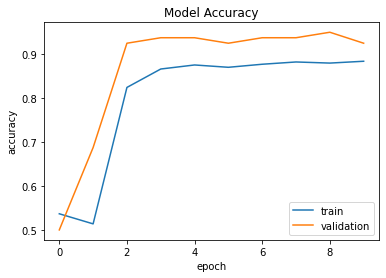

Test loss:  0.12526236474514008
Test accuracy:  0.949999988079071



              precision    recall  f1-score   support

     Class 0       0.98      0.92      0.95      1000
     Class 1       0.92      0.98      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [ ]:
model = train_model({
    'in_drop_out':0,
    'batch':256,
    'epochs':10,
    'aug_rotation':180,
    'aug_shift_w':0.10,
    'aug_shift_h':0.10,
    'aug_shear':0.10,
    'aug_zoom':0.10,
    'aug_horizontal_flip':True
})

<div dir='rtl'>


با مدل آموزش داده شده‌ی بالا توانستیم دقت ۹۵ درصد روی داده‌های تست به دست‌ آوریم.

حال می‌خواهیم قسمت‌های آموزش‌پذیر مدل را بیش‌تر کنیم و پس تابع آموزش را دوباره تعریف می‌کنیم.

In [ ]:
def train_model(config):
  input = Input((150, 150, 3))
  net = InceptionV3(include_top = False, weights = 'imagenet')(input)
  net = Conv2D(2, 3,padding='same',activation='relu')(net)
  net = Conv2D(2, 3,padding='same',activation='relu')(net)
  net = GlobalAveragePooling2D()(net)
  output = Activation('softmax')(net)

  model = Model(inputs = input, outputs = output)
  #Freezing InceptionV3.
  model.layers[1].trainable=False
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  model.summary()


  train_datagen = ImageDataGenerator(
        rotation_range=config['aug_rotation'],
        width_shift_range=config['aug_shift_w'],
        height_shift_range=config['aug_shift_h'],
        shear_range=config['aug_shear'],
        zoom_range=config['aug_zoom'],
        horizontal_flip=config['aug_horizontal_flip'],
        fill_mode='nearest'
  )

  train_generator = train_datagen.flow(train_X, train_Label, batch_size = config['batch'])

  validation_datagen = ImageDataGenerator()
  validation_generator = validation_datagen.flow(valid_X,valid_Label,config['batch'])

  history = model.fit(train_generator,
                                validation_data=validation_generator,
                                epochs = config['epochs'],
                                batch_size=config['batch'],
                                steps_per_epoch=math.ceil(7920/config['batch']),
                                validation_steps = math.ceil(80/config['batch'])
                                )
  
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','validation'],loc='lower right')
  plt.show()

  test_eval = model.evaluate(test_x, test_label, verbose = 0)
  print('Test loss: ', test_eval[0])
  print('Test accuracy: ', test_eval[1])
  print('\n\n')
  
  predictes_classes = model.predict(test_x)
  predicted_classes = np.argmax(np.round(predictes_classes), axis = 1)

  from sklearn.metrics import classification_report
  target_names = ["Class {}".format(i) for i in range(classes)]
  print(classification_report(test_vec, predicted_classes, target_names = target_names))

  return model

<div dir='rtl'>

در این مرحله چون تعداد متغیر‌های قابل‌اموزش مدل بیش‌تر شده بهتر است تعداد
epoch
های یادگیری را بیش‌تر کنیم تا شبکه زمان بیش‌تری برای ارزیابی و تطبیق شبکه با داده‌ها داشته باشد.

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
conv2d_660 (Conv2D)          (None, 3, 3, 2)           36866     
_________________________________________________________________
conv2d_661 (Conv2D)          (None, 3, 3, 2)           38        
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2)                 0         
_________________________________________________________________
activation_660 (Activation)  (None, 2)                 0         
Total params: 21,839,688
Trainable params: 36,904
Non-trainable params: 21,802,784
__________________________________________

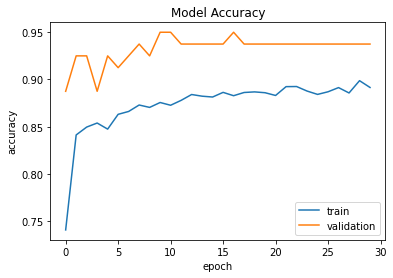

Test loss:  0.1143578365445137
Test accuracy:  0.9564999938011169



              precision    recall  f1-score   support

     Class 0       0.96      0.96      0.96      1000
     Class 1       0.96      0.95      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [ ]:
model = train_model({
    'in_drop_out':0,
    'batch':256,
    'epochs':30,
    'aug_rotation':180,
    'aug_shift_w':0.10,
    'aug_shift_h':0.10,
    'aug_shear':0.10,
    'aug_zoom':0.10,
    'aug_horizontal_flip':True
})

## نتیجه نهایی

<div dir='rtl'>

در این بخش توانستیم تصاویر سگ و گربه را با استفاده از شبکه‌های عصبی کانولوشنی و وزن‌های از پیش آموزش داده شده با دقت خیلی خوبی تفکیک کرده و مدل مناسبی با صحت روی داده‌های تست 96 درصد ارائه کنیم.